In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
n_times = 3
n_samples = 1e8

# Pure Python

In [3]:
import timeit

time = timeit.Timer("calc_pi((estimate_total_in_circle({}), ), {})".format(n_samples, n_samples),
                    "from pi import calc_pi, estimate_total_in_circle")
time.timeit(n_times) / n_times

55.83274231466445

# Numpy

In [4]:
%%writefile numpy_pi.py

import numpy as np


def numpy_calc_pi(n_samples):
    rand = np.random.uniform(size=(2, int(n_samples)))
    count = ((rand ** 2).sum(axis=0) <= 1).sum()
    return count * 4 / n_samples


Overwriting numpy_pi.py


In [5]:
from numpy_pi import numpy_calc_pi

numpy_calc_pi(n_samples)

3.14159656

In [6]:
import timeit

time = timeit.Timer("numpy_calc_pi({})".format(n_samples),
                    "from numpy_pi import numpy_calc_pi")
time.timeit(n_times) / n_times

2.7656896013310566

# Joblib

pip install joblib

In [7]:
%%writefile joblib_pi.py

from joblib import Parallel, delayed
from numpy_pi import numpy_calc_pi


def joblib_calc_pi(n_samples, n_jobs):
    residual = n_samples % n_jobs
    # get number of samples per worker
    n_samples_per_worker = int((n_samples - residual) / n_jobs)
    n_samples_per_process = (n_samples_per_worker, ) * n_jobs
    # apply residual for first worker
    n_samples_per_process = (int(n_samples_per_process[0] + residual), ) + n_samples_per_process[1:]
    # calc pi in parallel
    results = Parallel(n_jobs=n_jobs)(delayed(numpy_calc_pi)(sample) for sample in n_samples_per_process)
    
    count_list = [res * sample for res, sample in zip(results, n_samples_per_process)]
    return sum(count_list) / n_samples


Overwriting joblib_pi.py


In [8]:
from joblib_pi import joblib_calc_pi

joblib_calc_pi(n_samples, 2)

3.14166328

In [9]:
import timeit

time = timeit.Timer("joblib_calc_pi({}, 1)".format(n_samples),
                    "from joblib_pi import joblib_calc_pi")
time.timeit(n_times) / n_times

2.714584996002183

In [10]:
import tqdm
import timeit
from multiprocessing import cpu_count

results = {}
for i in tqdm.tqdm(range(1, cpu_count() + 1)):
    time = timeit.Timer("joblib_calc_pi({}, {})".format(n_samples, i),
                        "from joblib_pi import joblib_calc_pi")
    results[i] = time.timeit(n_times) / n_times


100%|██████████| 8/8 [00:35<00:00,  4.49s/it]


In [11]:
import pandas as pd

df = pd.Series(results).to_frame()
df.reset_index(inplace=True)
df.columns = ['number of process', 'time, s']
df['versus one'] = df.loc[0]['time, s'] / df['time, s']
df['parallel loss'] = 1 - df['versus one'] / df['number of process']
df['number of process'] = df['number of process'].astype(str)
df = df.round(4)
df.head().T

,0,1,2,3,4
number of process,1,2,3,4,5
"time, s",2.7486,1.6518,1.4283,1.2574,1.2492
versus one,1,1.664,1.9244,2.186,2.2002
parallel loss,0,0.168,0.3585,0.4535,0.56


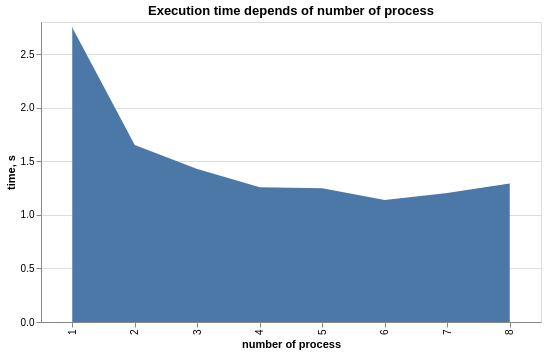

In [12]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='time, s'
).properties(
    title='Execution time depends of number of process',
    width=500,
    height=300
)

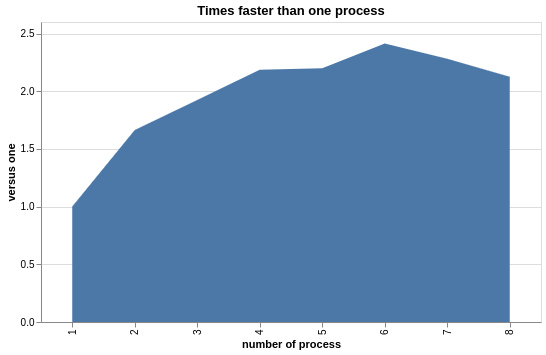

In [13]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='versus one'
).properties(
    title='Times faster than one process',
    width=500,
    height=300
)

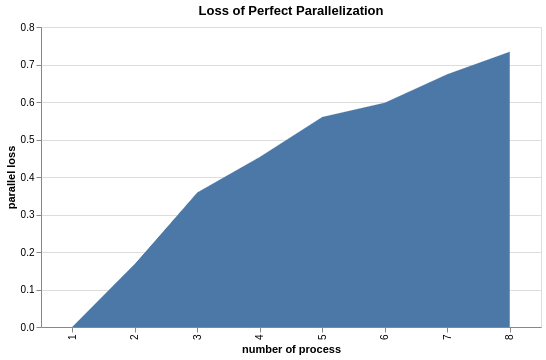

In [14]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='parallel loss'
).properties(
    title='Loss of Perfect Parallelization',
    width=500,
    height=300
)

# Numexpr

pip install numexpr

In [15]:
%%writefile numexpr_pi.py

import numexpr as ne
import numpy as np


def numexpr_pi(n_samples):
    rand = np.random.uniform(size=(2, int(n_samples)))
    s = ne.evaluate("sum(rand ** 2, axis=0)")
    return ne.evaluate("sum(where(s <= 1, 1, 0))") * 4 / n_samples


Overwriting numexpr_pi.py


In [16]:
from numexpr_pi import numexpr_pi

numexpr_pi(n_samples)

3.14163184

In [17]:
import timeit

time = timeit.Timer("numexpr_pi({})".format(n_samples),
                    "from numexpr_pi import numexpr_pi")
time.timeit(n_times) / n_times

3.052737187332241

# Numba

pip install numba

In [18]:
%%writefile numba_pi.py

from numba import jit
import numpy as np


@jit(forceobj=True)
def numpy_calc_pi(n_samples):
    rand = np.random.uniform(size=(2, int(n_samples)))
    count = ((rand ** 2).sum(axis=0) <= 1).sum()
    return count * 4 / n_samples


Overwriting numba_pi.py


In [19]:
from numba_pi import numpy_calc_pi

numpy_calc_pi(n_samples)

3.14147396

In [20]:
import timeit

time = timeit.Timer("numpy_calc_pi({})".format(n_samples),
                    "from numba_pi import numpy_calc_pi")
time.timeit(n_times) / n_times

2.7955577683314914

# Conclusion

- Numpy ~20x faster (2.8 vs 56 s) than pure python
- Joblib efficient up to number of phisical processors (speed up = n_cores / 2)
- Numexpr the same performance as numpy
- Numba the same performance as numpy